# Analysis of UTK FACE dataset and models

## Dataset

In [1]:
# Full dataset
import os
import glob
from IPython.display import display, Markdown

import numpy as np
import pandas as pd

dataset = r"C:\Users\thoma\Documents\_FAIRALGOS\utk-fairness-analysis\Dataset\UTKFace"

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())


def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

In [2]:
df = parse_dataset(dataset)
df.head()

,age,gender,race,file
0,100.0,male,white,C:\Users\thoma\Documents\_FAIRALGOS\utk-fairne...
1,100.0,male,white,C:\Users\thoma\Documents\_FAIRALGOS\utk-fairne...
2,100.0,female,white,C:\Users\thoma\Documents\_FAIRALGOS\utk-fairne...
3,100.0,female,white,C:\Users\thoma\Documents\_FAIRALGOS\utk-fairne...
4,100.0,female,white,C:\Users\thoma\Documents\_FAIRALGOS\utk-fairne...


In [3]:
print(f"Number of pictures: {len(df.index)}")

print(f"Min age: {df.age.min()}")
print(f"Max age: {df.age.max()}")

Number of pictures: 23705
Min age: 1.0
Max age: 116.0


### Visualizations

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('svg')

colors = ['#edf8e9','#c7e9c0','#a1d99b','#74c476','#31a354','#006d2c']

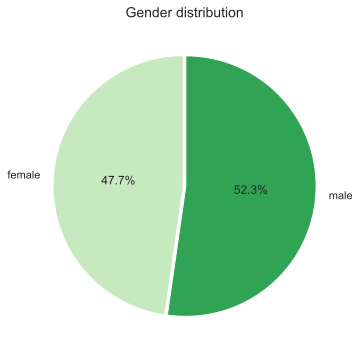

In [5]:
def plot_gender_distribution(df, title="Gender distribution"):
    gender = df['gender']

    labels = gender.value_counts().sort_index().index.tolist()
    counts = gender.value_counts().sort_index().values.tolist()

    # print(labels)
    # print(counts)

    pie, ax = plt.subplots(figsize=[10,6])
    plt.pie(counts, labels=labels, autopct="%.1f%%", explode=[0.01]*2, pctdistance=0.5, colors=[colors[1], colors[-2]], startangle=90)
    plt.title(title, fontsize=14)
    plt.show()

plot_gender_distribution(df)


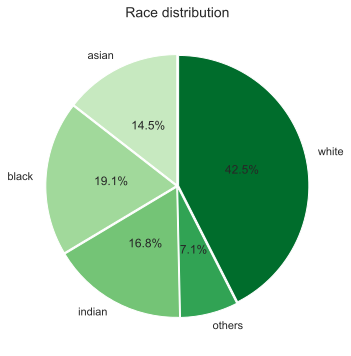

In [6]:
def plot_race_distribution(df, title="Race distribution"):
    race = df['race']

    labels = race.value_counts().sort_index().index.tolist()
    counts = race.value_counts().sort_index().values.tolist()

    # print(labels)
    # print(counts)

    pie, ax = plt.subplots(figsize=[10,6])
    plt.pie(counts, labels=labels, autopct="%.1f%%", explode=[0.01]*5, pctdistance=0.5, colors=colors[1:], startangle=90)
    plt.title(title, fontsize=14)
    plt.show()

plot_race_distribution(df)

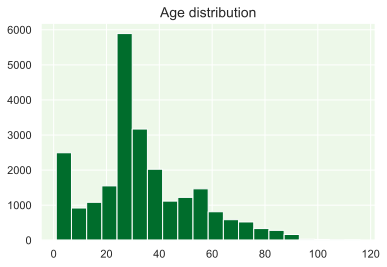

In [7]:
def plot_age_distribution(df, title="Age distribution", bins=20):
    sns.set(rc={'axes.facecolor':colors[0], 'figure.facecolor':'white'})

    plt.hist(df['age'], bins=bins, color=colors[-1])
    plt.title(title, fontsize=14);
    plt.show()

plot_age_distribution(df)

### Gender and age distributions grouped by race

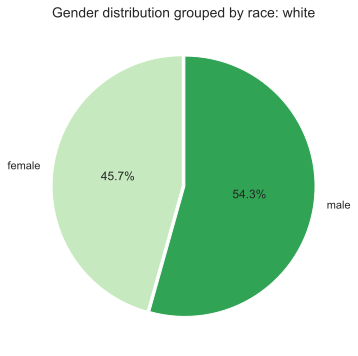

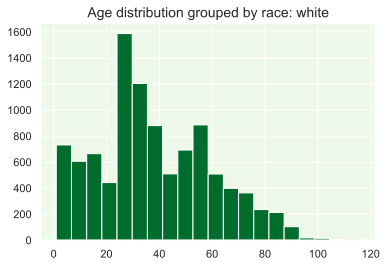

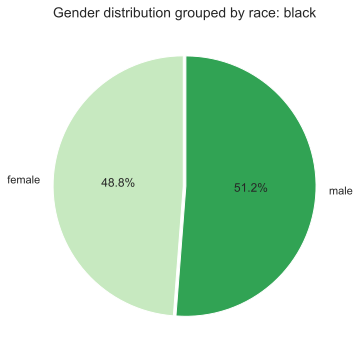

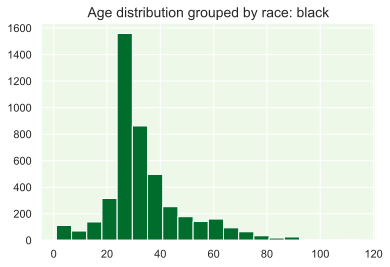

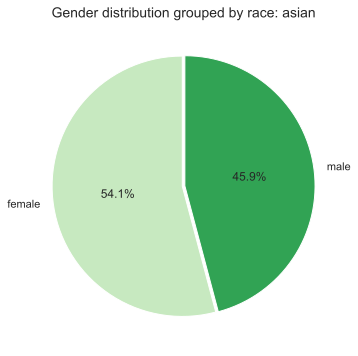

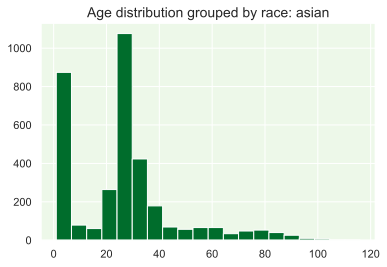

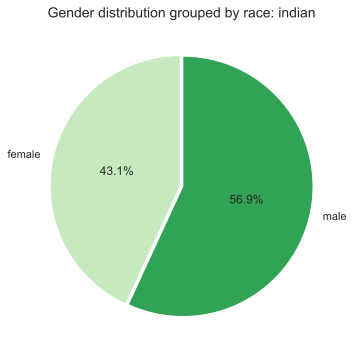

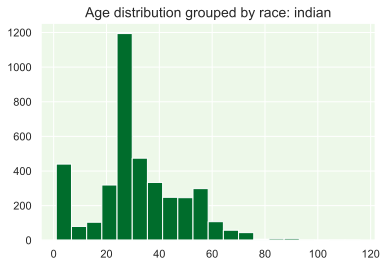

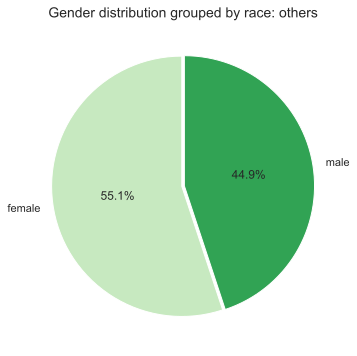

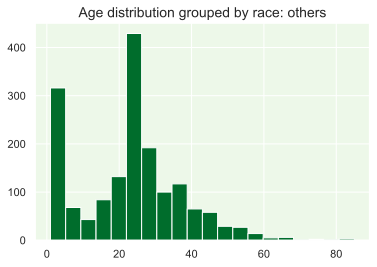

In [8]:
display(Markdown('### Gender and age distributions grouped by race'))

for race in dataset_dict['race_alias'].keys():
    df_race = df.loc[df['race'] == race]
    plot_gender_distribution(df_race, title=f"Gender distribution grouped by race: {race}")
    plot_age_distribution(df_race, title=f"Age distribution grouped by race: {race}")


### Gender and race distributions grouped by age

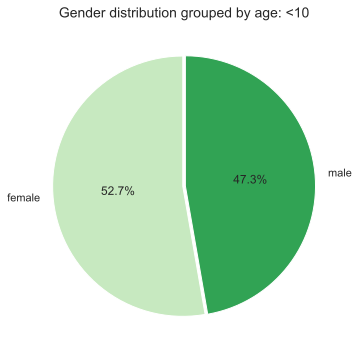

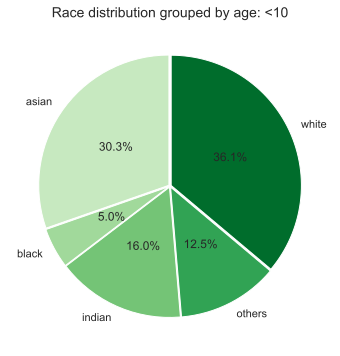

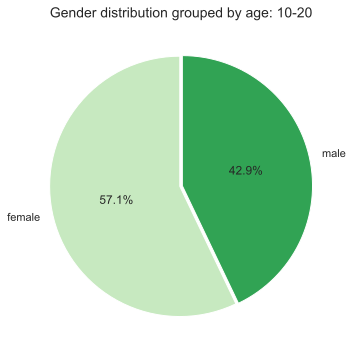

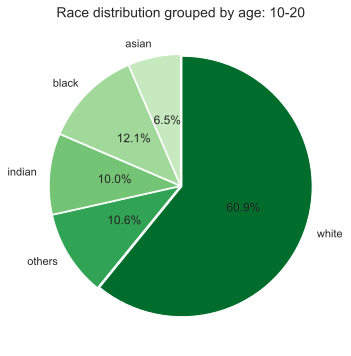

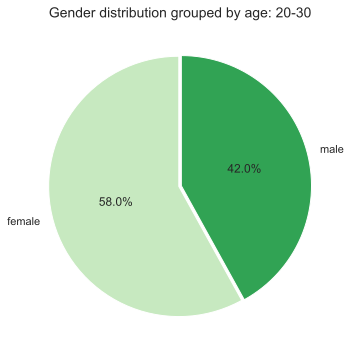

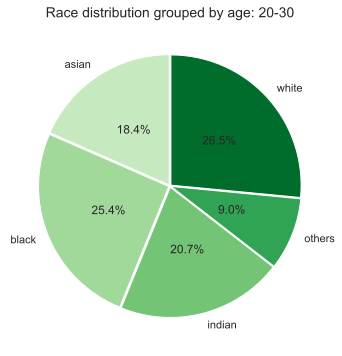

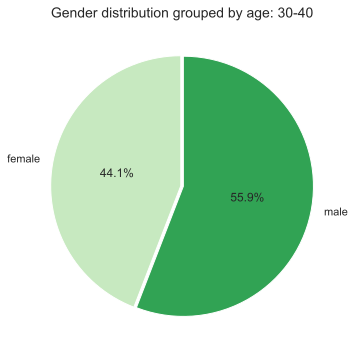

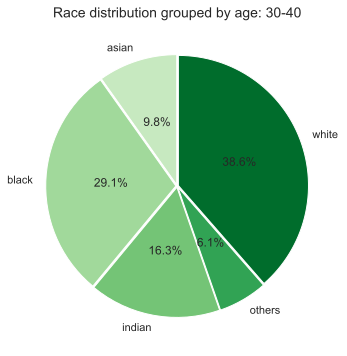

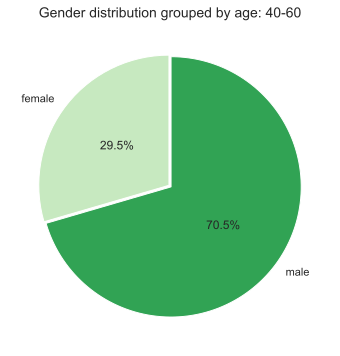

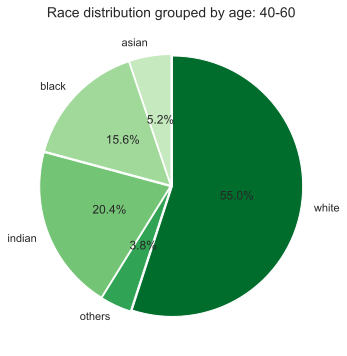

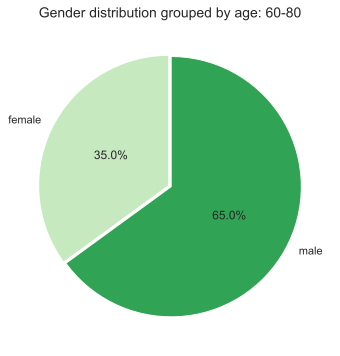

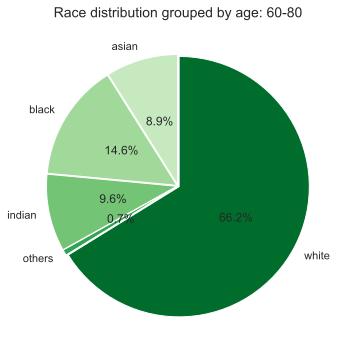

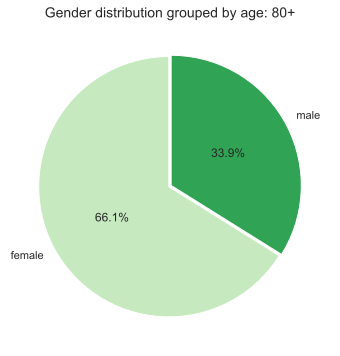

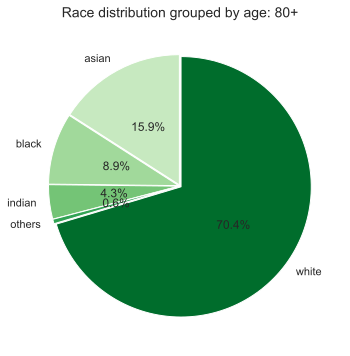

In [9]:
display(Markdown('### Gender and race distributions grouped by age'))


bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']

for i, name in enumerate(names):
    lower, upper = bins[i], bins[i+1]
    df_age = df.loc[(lower < df['age']) & (df['age'] < upper)]

    plot_gender_distribution(df_age, title=f"Gender distribution grouped by age: {name}")
    plot_race_distribution(df_age, title=f"Race distribution grouped by age: {name}")



## Model Analysis

In [10]:
predictions_path = r"C:\Users\thoma\Documents\_FAIRALGOS\utk-fairness-analysis\Predictions\df_predctions_all.csv"

df_predictions = pd.read_csv(predictions_path, index_col=0)
print(df_predictions.head())

   age_true  age_pred  race_true  race_pred  gender_true  gender_pred
0        30        29          0          0            0            1
1        26        35          4          1            1            1
2        24        27          2          0            1            1
3        23        36          3          0            0            0
4        42        36          0          0            1            1


In [11]:
from sklearn.metrics import classification_report, r2_score



display(Markdown("### Classification Report Gender"))
cr_gender = classification_report(df_predictions['gender_true'], df_predictions['gender_pred'], target_names=dataset_dict['gender_alias'].keys())
print(cr_gender)

display(Markdown("### Classification Report Race"))
cr_race = classification_report(df_predictions['race_true'], df_predictions['race_pred'], target_names=dataset_dict['race_alias'].keys())
print(cr_race)


def bound(x):
    if x < 1:
        return 1
    elif x > 116:
        return 116
    return x

display(Markdown("### R2 Score for Age"))
print('R2 score for age: ', r2_score(df_predictions['age_true'], df_predictions['age_pred'].apply(lambda x: bound(x))))

### Classification Report Gender

              precision    recall  f1-score   support

        male       0.90      0.91      0.90      3608
      female       0.90      0.89      0.90      3432

    accuracy                           0.90      7040
   macro avg       0.90      0.90      0.90      7040
weighted avg       0.90      0.90      0.90      7040



### Classification Report Race

              precision    recall  f1-score   support

       white       0.79      0.91      0.84      3004
       black       0.87      0.80      0.83      1336
       asian       0.77      0.84      0.80      1027
      indian       0.76      0.69      0.72      1160
      others       0.46      0.14      0.22       513

    accuracy                           0.79      7040
   macro avg       0.73      0.68      0.68      7040
weighted avg       0.77      0.79      0.77      7040



### R2 Score for Age

R2 score for age:  0.5214506793648123


## Check distribution in test set

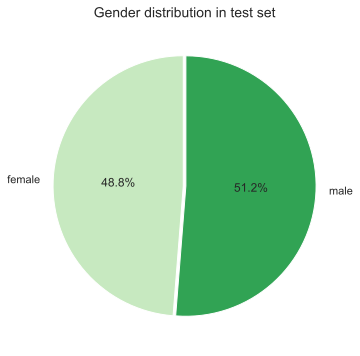

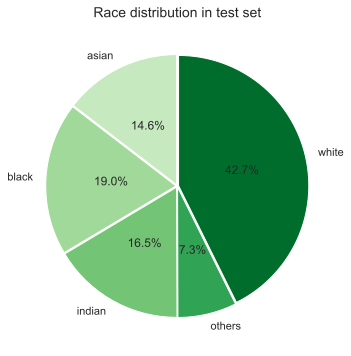

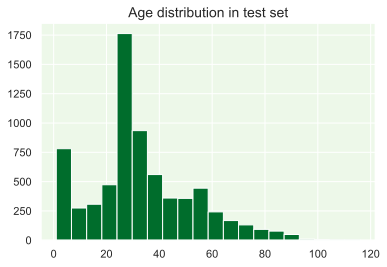

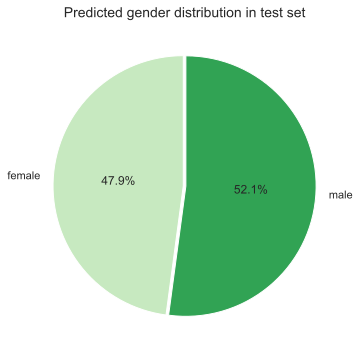

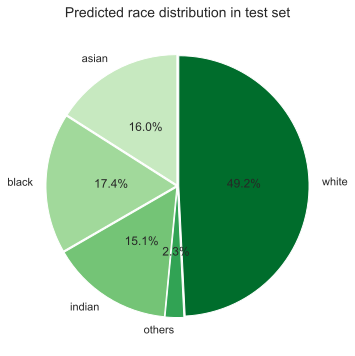

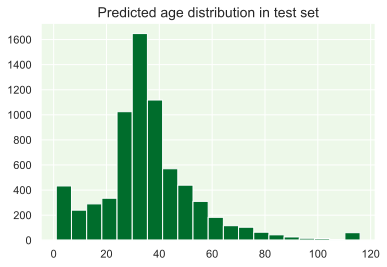

In [12]:
df_test = df_predictions.copy()

df_test['gender'] = df_test['gender_true'].apply(lambda x: dataset_dict['gender_id'][x])
df_test['race'] = df_test['race_true'].apply(lambda x: dataset_dict['race_id'][x])
df_test['age'] = df_test['age_true'].apply(lambda x: int(x))


plot_gender_distribution(df_test, title="Gender distribution in test set")
plot_race_distribution(df_test, title="Race distribution in test set")
plot_age_distribution(df_test, title="Age distribution in test set")


# def bound(x):
#     if x < 1:
#         return 1
#     elif x > 116:
#         return 116
#     return x

df_test['gender'] = df_test['gender_pred'].apply(lambda x: dataset_dict['gender_id'][x])
df_test['race'] = df_test['race_pred'].apply(lambda x: dataset_dict['race_id'][x])
df_test['age'] = df_test['age_pred'].apply(lambda x: bound(x))


plot_gender_distribution(df_test, title="Predicted gender distribution in test set")
plot_race_distribution(df_test, title="Predicted race distribution in test set")
plot_age_distribution(df_test, title="Predicted age distribution in test set")



## Fairness Metrics

   age  race  gender_true  gender_pred  pred_true
0   30     0            0            1          0
1   26     4            1            1          1
2   24     2            1            1          1
3   23     3            0            0          1
4   42     0            1            1          1
